# 1. Import packages

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error
from math import sqrt

# 2. Preprocessing

In [2]:
# past steps
n_steps = 200
# train test split percent
train_percent = 0.9

In [3]:
# build a univariate sequence
def build_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_index = i + n_steps
        # check if end index is over sequence
        if end_index + 1 > len(sequence):
            break
        # get input and output
        seq_x, seq_y = sequence[i:end_index], sequence[end_index]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [4]:
def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations 
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end], series[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

### 2.1 Load dataset

In [5]:
df = pd.read_csv("dataset_GBPUSD_EURUSD.csv")
spread = list(df["SPREAD"])

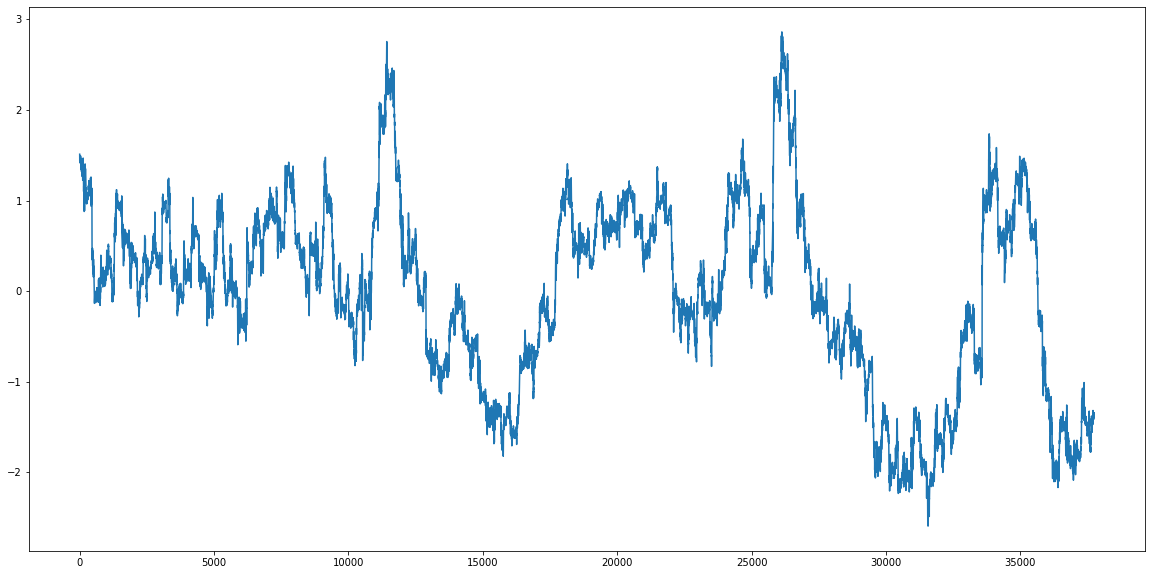

In [6]:
plt.figure(figsize=(20,10))
plt.plot(spread)
plt.show()

### 2.2 Split train and test dataset

In [7]:
train_size = int((len(spread) - n_steps) * train_percent)
train_dataset = spread[n_steps:train_size+n_steps]
test_dataset = spread[train_size + n_steps:]

In [8]:
print(len(spread))
print(train_size)
print(len(train_dataset))
print(len(test_dataset))

37749
33794
33794
3755


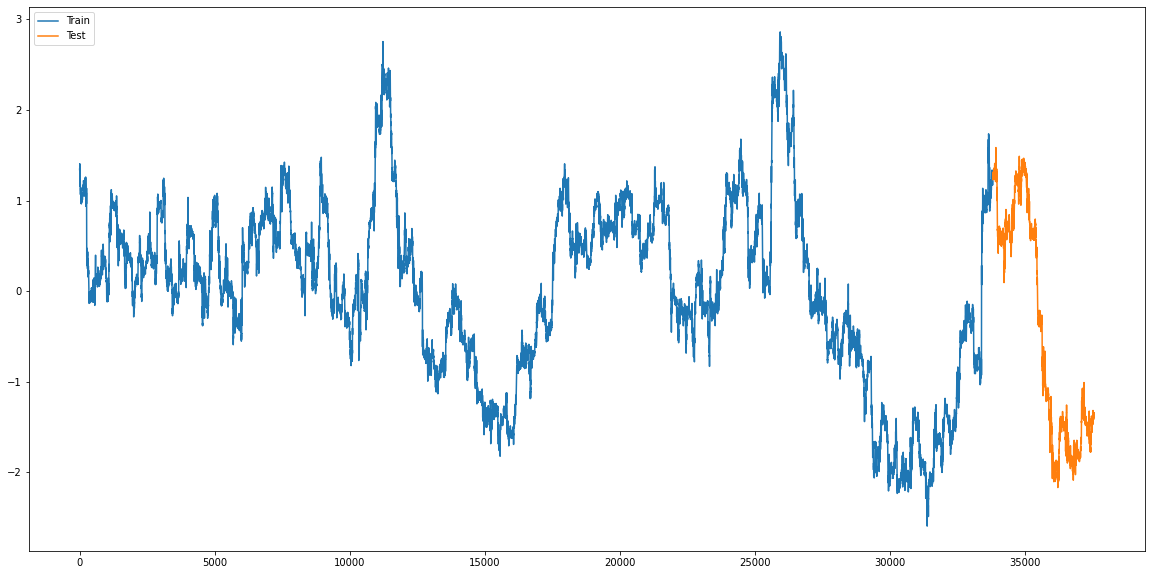

In [9]:
plt.figure(figsize=(20,10))
plt.plot(train_dataset)
plt.plot([None for i in train_dataset] + [x for x in test_dataset])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 2.3 Build Sequence

In [10]:
X, y = build_sequence(spread, n_steps)

### 2.4 Split train and test sequence

In [11]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [12]:
train_size = int(len(X) * train_percent)
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [13]:
print(len(X))
print(len(X_train))
print(len(X_test))

37549
33794
3755


In [24]:
X_train[-3:-1]

array([[[1.07043736],
        [1.05719429],
        [1.06674401],
        [1.05659948],
        [1.03466109],
        [1.05411741],
        [1.03969279],
        [1.02295646],
        [1.06050102],
        [1.07885692],
        [1.08849586],
        [1.07495538],
        [1.06597074],
        [1.03167343],
        [1.05289803],
        [1.0688611 ],
        [1.07917599],
        [1.00688801],
        [0.9877291 ],
        [1.02128289],
        [0.95266661],
        [0.95677634],
        [0.96191892],
        [0.97218241],
        [0.99479675],
        [1.17541664],
        [1.27377439],
        [1.32259363],
        [1.40915752],
        [1.39653901],
        [1.44919223],
        [1.44460664],
        [1.49974192],
        [1.57868926],
        [1.50315404],
        [1.41381067],
        [1.57485529],
        [1.50100721],
        [1.50722046],
        [1.62542115],
        [1.67441075],
        [1.54065528],
        [1.43071187],
        [1.52782858],
        [1.56055771],
        [1

# 3. Build the Model

In [30]:
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [31]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
None


# 4. Train

In [32]:
# fit model
history = model.fit(X_train, y_train, epochs=4)

Epoch 1/4
1057/1057 [==============================] - 100s 92ms/step - loss: 0.0099
Epoch 2/4
1057/1057 [==============================] - 97s 91ms/step - loss: 0.0021
Epoch 3/4
1057/1057 [==============================] - 97s 91ms/step - loss: 0.0017
Epoch 4/4
1057/1057 [==============================] - 99s 93ms/step - loss: 0.0016


dict_keys(['loss'])


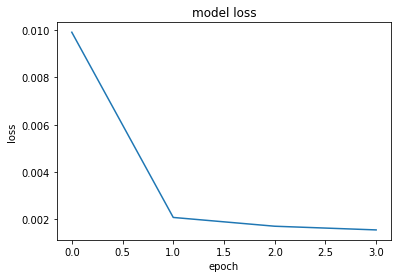

In [33]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# 5. Evaluate the Model

In [34]:
predictions = []
for x_input in X_test:
    x_input = x_input.reshape((1, n_steps, n_features))
#     print(x_input)
    yhat = model.predict(x_input)
#     print(yhat)
    predictions.append(yhat[0][0])

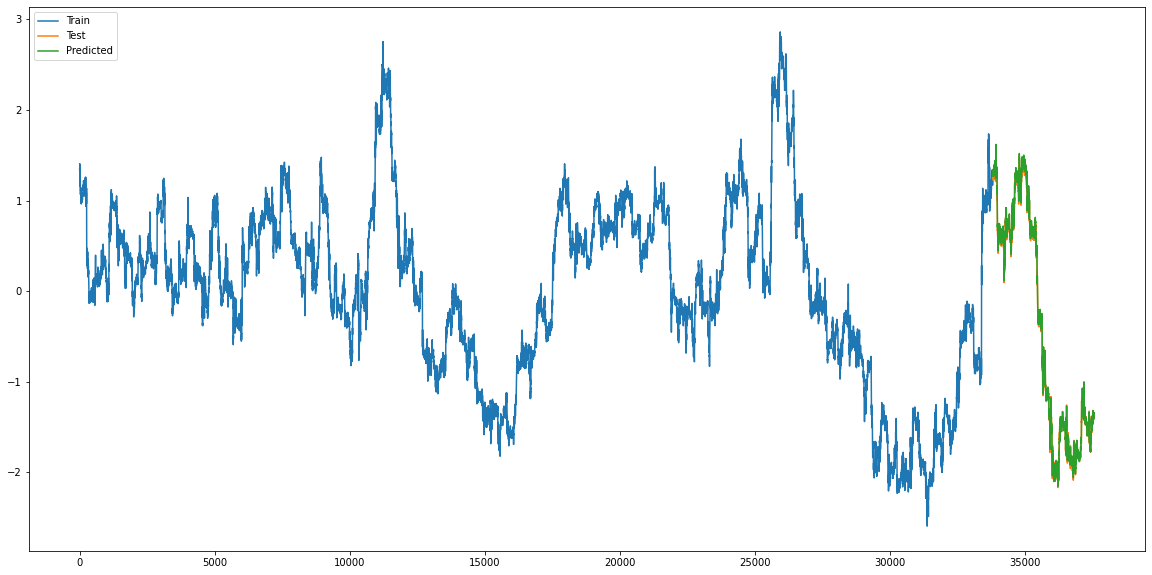

In [35]:
plt.figure(figsize=(20,10))
plt.plot(train_dataset)
plt.plot([None for i in train_dataset] + [x for x in test_dataset])
plt.plot([None for i in train_dataset] + [x for x in predictions])
plt.legend(['Train', 'Test', 'Predicted'], loc='upper left')
plt.show()

In [36]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    return mean_squared_error(actual, predicted , squared=True)

In [37]:
RMSE = evaluate_forecasts(test_dataset, predictions)

In [38]:
RMSE

0.0018213446725879967

# 6. Forecasting 7 days(12\*24\*7 = 2016 steps)

In [42]:
prediction_steps = 2016
# demonstrate prediction
forecasted = []

x_input = X_test[-1:]
x_input = np.delete(x_input, 0)
x_input = np.append(x_input, spread[-1])
x_input = x_input.reshape((1, n_steps, n_features))
# print(x_input)

for i in range(prediction_steps):
    yhat = model.predict(x_input)
    forecasted.append(yhat[0][0])
#     print(yhat)
    x_input = np.delete(x_input, 0)    
    x_input = np.append(x_input, yhat[0][0])
    
    x_input = x_input.reshape((1, n_steps, n_features))
#     print(x_input)

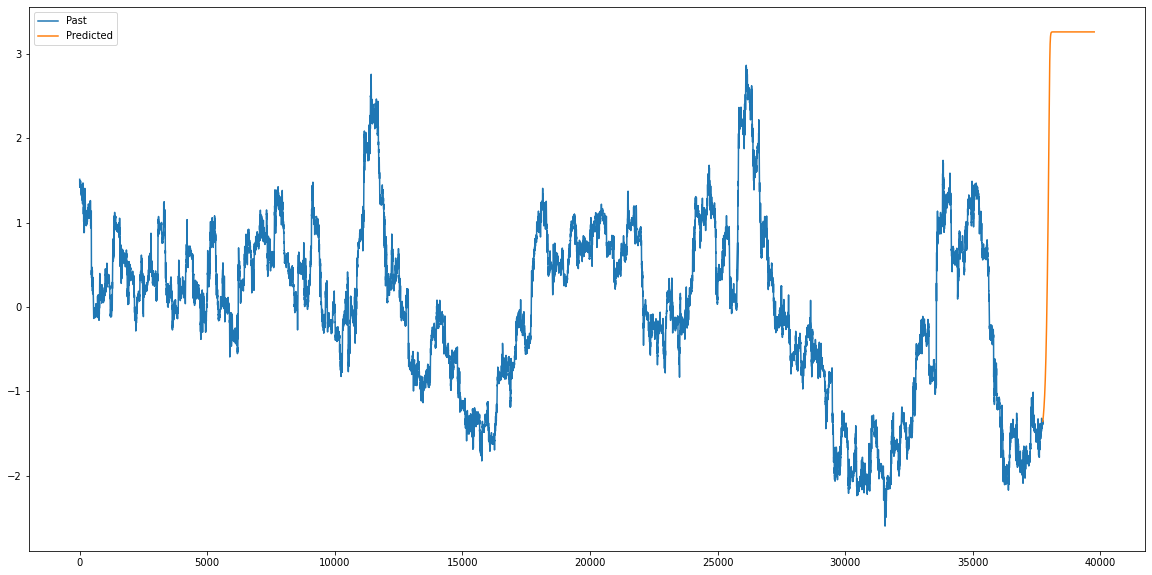

In [43]:
plt.figure(figsize=(20,10))
plt.plot(spread)
plt.plot([None for i in spread] + [x for x in forecasted])
plt.legend(['Past', 'Predicted'], loc='upper left')
plt.show()